In [ ]:
#ex 1

In [ ]:
import pyod
import scipy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from matplotlib.pyplot import scatter
from sklearn.datasets import make_blobs

In [ ]:
n_samples = 500
centers = [[0.0, 0.0]]
cluster_std = 2.0
contamination = 0.1

X, y_true_clusters = make_blobs(
    n_samples=n_samples,
    centers=centers,
    cluster_std=cluster_std,
    n_features=2,
)

plt.scatter(X[:, 0], X[:, 1], c=y_true_clusters)
plt.title("Clusters")
plt.show()

In [ ]:
from numpy.random import multivariate_normal

In [ ]:
projection_array = [multivariate_normal(mean = [0, 0], cov = np.identity(2)) for _ in range(5)]

norms = np.linalg.norm(projection_array, axis = 1, keepdims=True)

unit_values = projection_array / norms

projected_data = X.dot(unit_values.T)

plt.scatter(projected_data[:, 0], projected_data[:, 1], c=y_true_clusters)
plt.title("Projection")
plt.show()

In [ ]:
plt.hist(projected_data)
plt.title("Histogram")
plt.show()

In [ ]:
hist_array = []

n_bins = 10

for i in range(5):
  projected_values = projected_data[:, i]

  min_range = projected_values.min()
  max_range = projected_values.max()

  hist_range = (min_range-1, max_range+1)

  hist_data, bin_edges = np.histogram(projected_values, bins = n_bins, range = hist_range)

  probabilities = hist_data / n_samples

  hist_array.append({'bin_edges': bin_edges, 'probs': probabilities})

sample_probabilites = np.zeros_like(projected_data)

for i in range(5):
  hist_info = hist_array[i]
  probs = hist_info['probs']
  bin_edges = hist_info['bin_edges']

  all_sample_values = projected_data[:, i]

  bin_indices = np.digitize(all_sample_values, bin_edges) - 1

  bin_indices_clipped = np.clip(bin_indices, 0, n_bins - 1)

  sample_probabilites[:, i] = probs[bin_indices_clipped]

anomaly_scores = np.mean(sample_probabilites, axis = 1)

In [ ]:
X_test = np.random.uniform(
        low=-3.0,
        high=3.0,
        size=(500, 2)
    )


In [ ]:
# class for ex 1

In [ ]:
N_SAMPLES_TRAIN = 500
CENTERS_TRAIN = [[0.0, 0.0]]
CLUSTER_STD_TRAIN = 2.0
N_FEATURES = 2

N_SAMPLES_TEST = 500
TEST_LOW = -3.0
TEST_HIGH = 3.0

N_PROJECTIONS = 5
N_BINS = 10
RANDOM_SEED = 42

In [ ]:
class AnomalyDetector:
    def __init__(self, n_projections=5, n_bins=10, random_state=None):
        self.n_projections = n_projections
        self.n_bins = n_bins
        self.random_state = random_state

        # These will be set during the 'fit' method
        self.unit_vectors_ = None
        self.histogram_data_ = []
        self._rng = np.random.default_rng(random_state)

    def fit(self, X):
        _, n_features = X.shape
        n_samples = X.shape[0]

        # 1. Create projection vectors
        random_vectors = self._rng.multivariate_normal(
            mean=np.zeros(n_features),
            cov=np.identity(n_features),
            size=self.n_projections
        )
        norms = np.linalg.norm(random_vectors, axis=1, keepdims=True)
        self.unit_vectors_ = random_vectors / norms

        # 2. Build histograms
        projected_data_train = X.dot(self.unit_vectors_.T)
        self.histogram_data_ = []

        for i in range(self.n_projections):
            projection_values = projected_data_train[:, i]

            min_val = projection_values.min()
            max_val = projection_values.max()
            padding = (max_val - min_val) * 0.1
            hist_range = (min_val - padding, max_val + padding)

            counts, bin_edges = np.histogram(
                projection_values,
                bins=self.n_bins,
                range=hist_range
            )

            probabilities = counts / n_samples
            self.histogram_data_.append({'probs': probabilities, 'edges': bin_edges})

        return self

    def score(self, X):
        projected_data_test = X.dot(self.unit_vectors_.T)
        sample_probabilities = np.zeros_like(projected_data_test)

        for i in range(self.n_projections):
            hist_info = self.histogram_data_[i]
            probabilities = hist_info['probs']
            bin_edges = hist_info['edges']

            all_sample_values_test = projected_data_test[:, i]

            bin_indices = np.digitize(all_sample_values_test, bin_edges) - 1
            bin_indices_clipped = np.clip(bin_indices, 0, self.n_bins - 1)

            sample_probabilities[:, i] = probabilities[bin_indices_clipped]

        anomaly_scores = np.mean(sample_probabilities, axis=1)
        return anomaly_scores


In [ ]:
def generate_training_data():
    X, _ = make_blobs(
        n_samples=N_SAMPLES_TRAIN,
        centers=CENTERS_TRAIN,
        cluster_std=CLUSTER_STD_TRAIN,
        n_features=N_FEATURES,
    )
    return X

def generate_test_data():
    X_test = np.random.uniform(
        low=TEST_LOW,
        high=TEST_HIGH,
        size=(N_SAMPLES_TEST, N_FEATURES)
    )
    return X_test

def plot_scores(X_test, anomaly_scores):
    plt.figure(figsize=(10, 8))

    scatter = plt.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=anomaly_scores,
        cmap='viridis',
        alpha=0.7
    )

    plt.colorbar(scatter, label='Anomaly Score (Mean Probability)')
    plt.title('Test Dataset (Uniform) with Anomaly Scores')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('equal')

    plt.show()


In [ ]:
if __name__ == "__main__":
    np.random.seed(RANDOM_SEED)

    # 1. Generate Data
    X_train = generate_training_data()
    X_test = generate_test_data()

    # 2. Create, Fit, and Score
    # Initialize the detector
    detector = AnomalyDetector(
        n_projections=N_PROJECTIONS,
        n_bins=N_BINS,
        random_state=RANDOM_SEED
    )

    # "Train" the detector on the training data
    detector.fit(X_train)

    # "Test" the detector on the new data
    scores = detector.score(X_test)

    # 3. Plot results
    plot_scores(X_test, scores)


In [ ]:
#ex 2

In [36]:
import numpy as np
import pyod as po
from pyod.models.iforest import IForest
from pyod.models.loda import LODA
from pyod.models.dif import DIF
from pyod.utils.utility import standardizer
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from pyod.utils.utility import standardizer
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

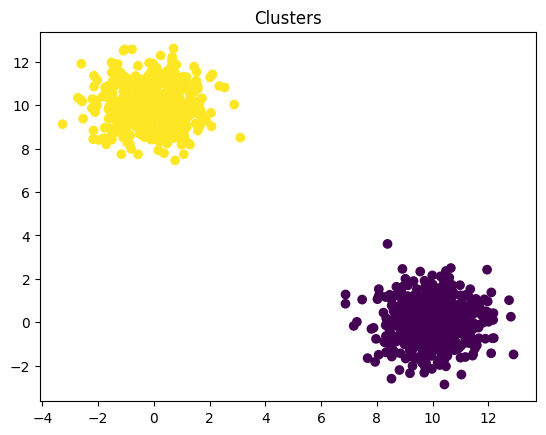

In [37]:
X,y = sk.datasets.make_blobs(n_samples=[500,500],cluster_std=[1,1],centers=[(10,0),(0,10)])
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Clusters")
plt.show()

In [39]:
iforest = IForest(contamination=0.02)
iforest.fit(X)
Test = np.random.uniform(low=-10,high=20,size=(1000,2))
predict = iforest.decision_function(Test)

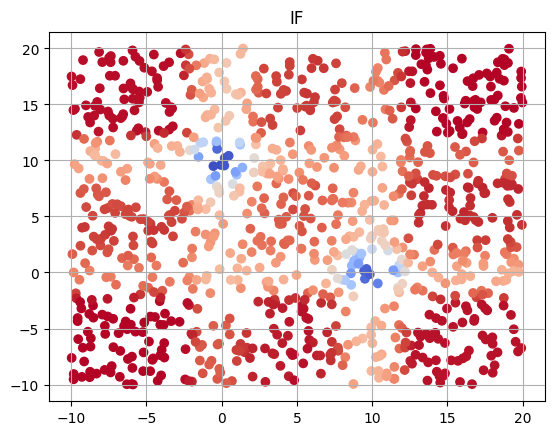

In [40]:
plt.scatter(
    Test[:, 0],
    Test[:, 1],
    c=predict,
    cmap='coolwarm'
)

plt.title("IF")
plt.grid(True)
plt.show()

In [44]:
dif = DIF(hidden_neurons=[100,50],contamination=0.02)
dif.fit(X)
predict = dif.decision_function(Test)

WTF
done


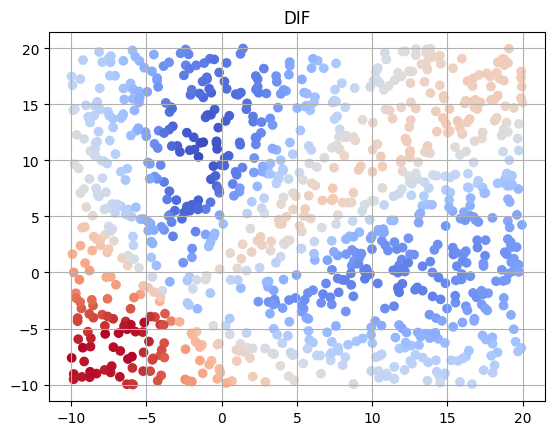

In [42]:
plt.scatter(
    Test[:, 0],
    Test[:, 1],
    c=predict,
    cmap='coolwarm'
)

plt.title("DIF")
plt.grid(True)
plt.show()

In [45]:
loda = LODA(n_bins=10,contamination=0.02) #100,10,40
loda.fit(X)
predict = loda.decision_function(Test)

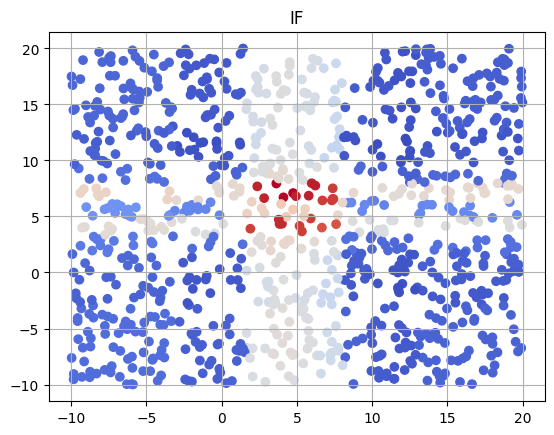

In [46]:
plt.scatter(
    Test[:, 0],
    Test[:, 1],
    c=predict,
    cmap='coolwarm'
)

plt.title("IF")
plt.grid(True)
plt.show()

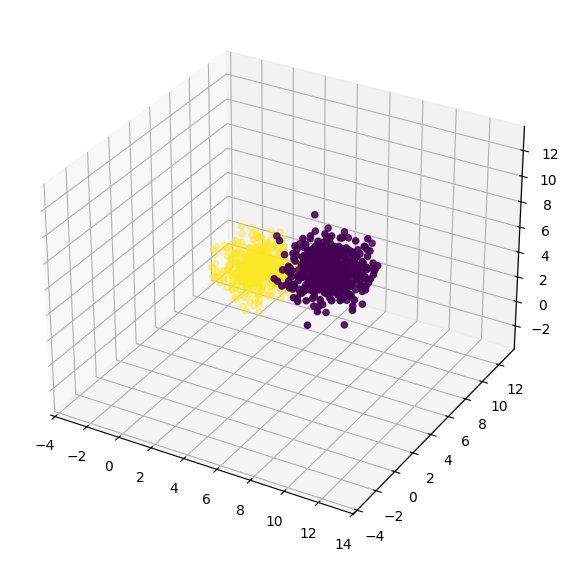

In [47]:
#3D
X,y = sk.datasets.make_blobs(n_samples=[500,500], n_features=3,cluster_std=[1,1],centers=[(10,0,10),(0,10,0)])

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)

In [48]:
iforest = IForest(contamination=0.02)
iforest.fit(X)
Test = np.random.uniform(low=-10,high=20,size=(1000,3))
predict = iforest.decision_function(Test)

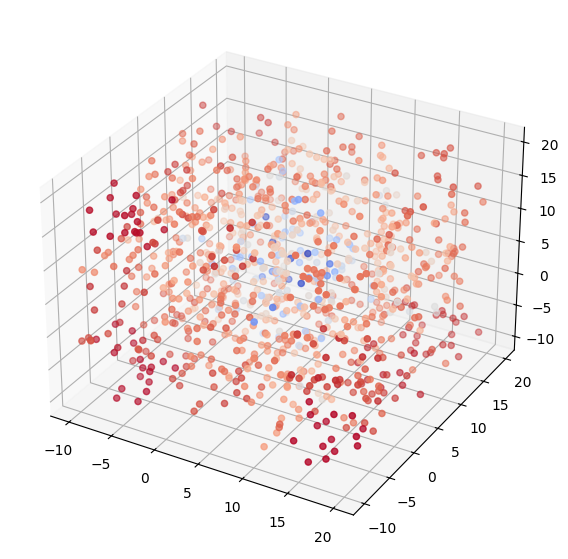

In [49]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Test[:, 0], Test[:, 1], Test[:, 2], c=predict, cmap = 'coolwarm')

In [50]:
dif = DIF(hidden_neurons=[100,50],contamination=0.02)
dif.fit(X)
predict = dif.decision_function(Test)

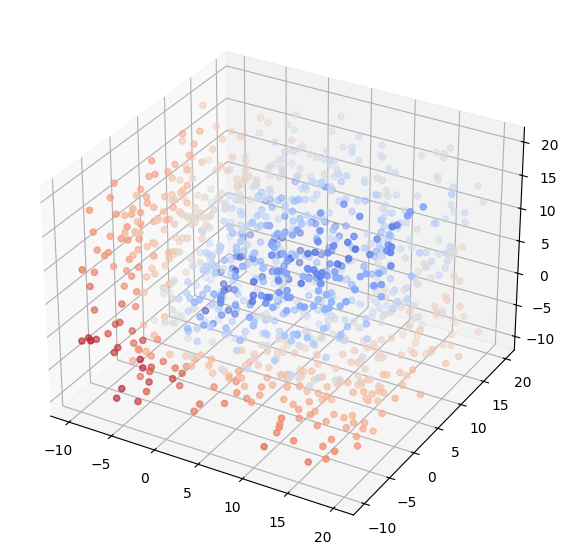

In [51]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Test[:, 0], Test[:, 1], Test[:, 2], c=predict, cmap = 'coolwarm')

In [52]:
loda = LODA(n_bins=40,contamination=0.02) #100,10,40
loda.fit(X)
predict = loda.decision_function(Test)

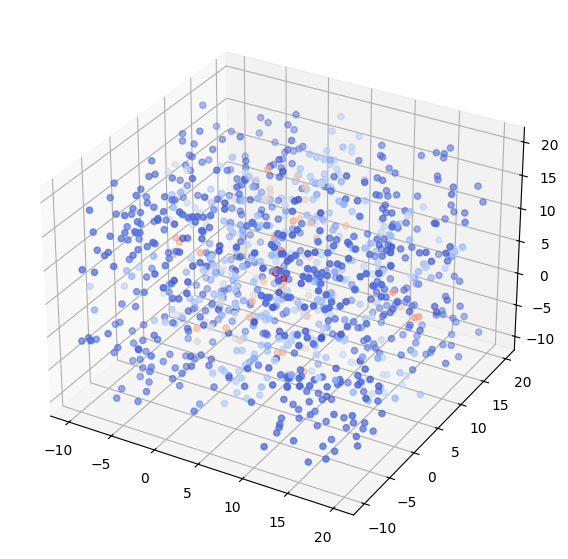

In [53]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Test[:, 0], Test[:, 1], Test[:, 2], c=predict, cmap = 'coolwarm')

In [ ]:
# ex 3

In [29]:
import numpy as np
from pyod.models.loda import LODA
from pyod.models.dif import DIF
from scipy.io import loadmat

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [ ]:
def run_experiment():
    # 1. Load Data
    data = loadmat('shuttle.mat')
    X = data['X']
    y = data['y'].ravel()

    # Store results for each run
    results = {
        'IForest': {'BA': [], 'ROC_AUC': []},
        'LODA': {'BA': [], 'ROC_AUC': []},
        'DIF': {'BA': [], 'ROC_AUC': []}
    }

    n_runs = 1

    for i in range(n_runs):
        # Split data (40% test size)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.4,
            random_state=i,  # Use loop variable for different splits
            stratify=y      # Good practice for imbalanced datasets
        )

        # Normalize data
        scaler = StandardScaler()
        X_train_norm = scaler.fit_transform(X_train)
        X_test_norm = scaler.transform(X_test)

        # Calculate contamination (proportion of outliers in training)
        # This is used by some models like IsolationForest
        contamination = np.mean(y_train)
        if contamination == 0:
             # Handle rare case where no outliers are in train split
             contamination = 'auto'

        # 2. Fit models and evaluate
        models = {
            'IForest': IsolationForest(contamination=contamination, random_state=i),
            'LODA': LODA(),
            'DIF': DIF(random_state=i)
        }

        print ("Got here")
        for name, model_object in models.items():
            print(f"Key: {name}")
            print(f"Value: {model_object}\n")

        for name, model in models.items():
            print ("Keep it going1")
            model.fit(X_train_norm)
            print ("Keep it going2")
            print (name)

            y_pred = model.predict(X_test_norm)

            print (name)
            # Get anomaly scores (for ROC AUC)
            y_scores = model.decision_function(X_test_norm)
            print ("y_scores")

            if name == 'IForest':
                # sklearn IForest: 1=inlier, -1=outlier.
                # We map to 0=inlier, 1=outlier
                y_pred = np.where(y_pred == -1, 1, 0)

                # sklearn IForest: higher score = inlier.
                # Metrics expect: higher score = outlier.
                # So we invert the scores.
                y_scores = -y_scores

            # pyod models (LODA, DIF) already output:
            # predict: 0=inlier, 1=outlier
            # decision_function: higher score = outlier
            # ...so no conversion is needed for them.

            # Compute metrics
            ba = balanced_accuracy_score(y_test, y_pred)
            print ("ba")
            roc_auc = roc_auc_score(y_test, y_scores)
            print ("roc_auc")

            # Store results
            results[name]['BA'].append(ba)
            print ("results")
            results[name]['ROC_AUC'].append(roc_auc)
            print ("results")

    # 3. Compute and print mean scores
    print("\n--- Mean Results over 10 Runs (Mean ± Std. Dev.) ---")
    print(f"{'Model':<10} | {'Balanced Accuracy':<25} | {'ROC AUC':<25}")
    print("-" * 64)

    for name, metrics in results.items():
        ba_mean = np.mean(metrics['BA'])
        ba_std = np.std(metrics['BA'])
        roc_mean = np.mean(metrics['ROC_AUC'])
        roc_std = np.std(metrics['ROC_AUC'])

        print(f"{name:<10} | {ba_mean:.4f} ± {ba_std:.4f}{' ':<13} | {roc_mean:.4f} ± {roc_std:.4f}")

if __name__ == "__main__":
    run_experiment()


Got here
Key: IForest
Value: IsolationForest(contamination=np.float64(0.07152556181682396), random_state=0)

Key: LODA
Value: LODA(contamination=0.1, n_bins=10, n_random_cuts=100)

Key: DIF
Value: DIF(batch_size=1000, contamination=0.1, device=device(type='cpu'),
  hidden_activation='tanh', hidden_neurons=[500, 100], max_samples=256,
  n_ensemble=50, n_estimators=6, random_state=0, representation_dim=20,
  skip_connection=False)

Keep it going1
Keep it going2
IForest
IForest
y_scores
ba
roc_auc
results
results
Keep it going1
Keep it going2
LODA
LODA
y_scores
ba
roc_auc
results
results
Keep it going1
